# Problem
Insurance companies that sell life, health, and property and casualty insurance are using machine learning (ML) to drive improvements in customer service, fraud detection, and operational efficiency. This company provides Vehicle Insurance to its customers. I want to identify the customers segments which will be more willing to buy insurance.


# Dateset informations

* id - customerID 
* Gender - client gender
* Age - client age 
* Driving_License - possesion of driving license 
* Region_code - client region code 
* Previously_Insured - was client previously insured 
* Vehicle_Age - represents the age of insured vehicle 
* Vehicle_Damage - was vehicle damaged 
* Annual_Premium - the price of dues
* Policy_Sales_Channel - distribution channels to sell insurances
* Vingate - the number of days a customer has been insured up until now 
* Response - target 


# Imports

In [9]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# data processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# models trainng
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

# models validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve
import scipy.stats as ss
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

# algorithms
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost.sklearn import XGBClassifier

# remove annoying warnings
import warnings
warnings.filterwarnings('ignore')

# Data import

In [16]:
data = pd.read_csv('aug_train.csv')

In [13]:
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,17163,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,32023,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,87447,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,501933,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


# Basic data exploration

In [348]:
data.shape

(382154, 12)

In [349]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    382154 non-null  int64  
 1   Gender                382154 non-null  object 
 2   Age                   382154 non-null  int64  
 3   Driving_License       382154 non-null  int64  
 4   Region_Code           382154 non-null  float64
 5   Previously_Insured    382154 non-null  int64  
 6   Vehicle_Age           382154 non-null  object 
 7   Vehicle_Damage        382154 non-null  object 
 8   Annual_Premium        382154 non-null  float64
 9   Policy_Sales_Channel  382154 non-null  float64
 10  Vintage               382154 non-null  int64  
 11  Response              382154 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 35.0+ MB


In [350]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [351]:
data.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,382154.000,382154.000,382154.000,382154.000,382154.000,382154.000,382154.000,382154.000,382154.000
mean,234392.953,38.546,0.998,26.407,0.489,30711.271,111.940,154.189,0.164
std,139527.487,15.227,0.043,13.181,0.500,17061.596,54.287,83.735,0.370
min,1.000,20.000,0.000,0.000,0.000,2630.000,1.000,10.000,0.000
25%,115006.250,25.000,1.000,15.000,0.000,24546.000,26.000,81.000,0.000
50%,230461.500,36.000,1.000,28.000,0.000,31692.000,145.000,154.000,0.000
75%,345434.750,49.000,1.000,35.000,1.000,39447.750,152.000,227.000,0.000
max,508145.000,85.000,1.000,52.000,1.000,540165.000,163.000,299.000,1.000


# Checking for missing values

In [352]:
nans = data.isnull().sum()
nans

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

There are no missing values in this dataset.

## Creating lists of indexes for numeric and categorial columns.

In this step I am creating two lists - one for numeric features and other for categorial. Then I will use it to make a separate analysis for those types of features.

In [353]:
numerical_columns = data.select_dtypes(include=np.number).columns.tolist()
numerical_columns

['id',
 'Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage',
 'Response']

In [354]:
# Response is our target not a decision variable, so I removed it from numerical list.
numerical_columns.remove('Response')
numerical_columns

['id',
 'Age',
 'Driving_License',
 'Region_Code',
 'Previously_Insured',
 'Annual_Premium',
 'Policy_Sales_Channel',
 'Vintage']

In [355]:
categorial_columns = data.select_dtypes(exclude=np.number).columns.tolist()
categorial_columns

['Gender', 'Vehicle_Age', 'Vehicle_Damage']

# Is dataset imbalanced?

In this step I want to check if our dataset is imbalanced. Imbalanced datasets are demanding for classification problems, because there is an unequal distribuation of classes. For that reason models have poor predictive performance, specifically for the minority class. If our problem will be imbalanced, I will have to use methods for imbalanced datasets to improve models accuracy.

In [356]:
# making a target variable
target = data.Response

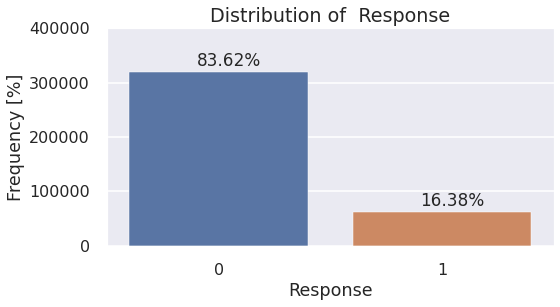

In [360]:
plt.figure(figsize=(8,4))
ax = sns.countplot(target)
plt.title('Distribution of  Response')
plt.ylabel('Frequency [%]')
plt.ylim(top=400000)
for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/len(target))
    ax.annotate(percentage, (p.get_x()+0.30, p.get_height()+10000))
plt.show()

Problem is imbalanced because only 16,38% of customers are interested in having vehicle insurance. This bias in the training dataset can influence machine learning algorithms, leading some to ignore the minority class entirely. Therefore I will use resampling methods to make this problem balanced and imporve machine learning algorithms.

# Numerical columns analysis.

In this step I am creating two loops. First one is for counting and checking unique values for each numeric feature. Second one is for plotting histograms.

In [361]:
for col in numerical_columns:
    print(f'{col}')
    print(f'unique values number: {data[col].nunique()}')
    print(f'{data[col].unique()}')
    print()

id
unique values number: 382154
[167647  17163  32023 ... 165293 383241 401019]

Age
unique values number: 66
[22 42 66 28 25 51 38 45 26 33 76 23 49 52 24 21 48 35 36 44 60 57 56 73
 54 50 72 58 41 27 61 59 29 64 37 46 31 68 39 63 40 30 62 69 65 78 79 55
 74 47 34 67 53 70 32 43 71 20 77 75 80 81 85 83 82 84]

Driving_License
unique values number: 2
[1 0]

Region_Code
unique values number: 53
[ 7. 28. 33. 46. 25.  8. 41. 39. 13. 14. 36.  3. 43. 45. 48. 11. 30. 15.
  6. 50. 38. 19. 34. 22. 29. 35. 12. 37.  4. 10. 40. 24. 31. 21.  2. 52.
  9. 49.  5. 47.  1. 20. 42. 27. 26. 32. 18. 16. 17. 51.  0. 23. 44.]

Previously_Insured
unique values number: 2
[1 0]

Annual_Premium
unique values number: 48993
[ 2630. 43327. 35841. ... 68063. 67176. 49322.]

Policy_Sales_Channel
unique values number: 156
[152.  26. 124. 122. 158. 157. 156. 160.  24. 153.  55.   1.   8.  88.
  13.  11. 163. 151.   7.   9.  15.  31. 120.  30. 150.  25.  61. 154.
  64. 155. 113. 108. 125.  52. 121.  16.  44.  14.  29.

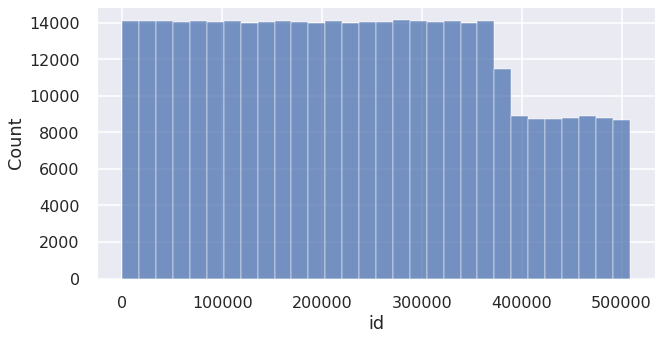

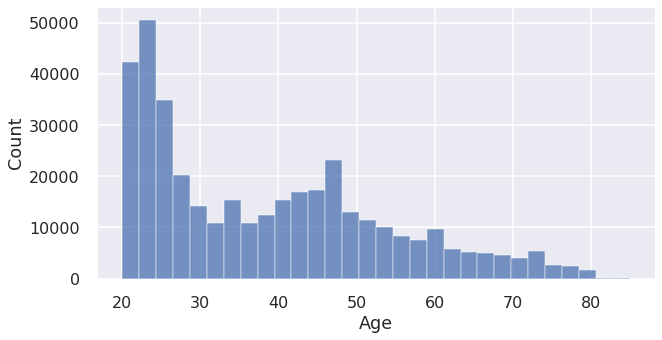

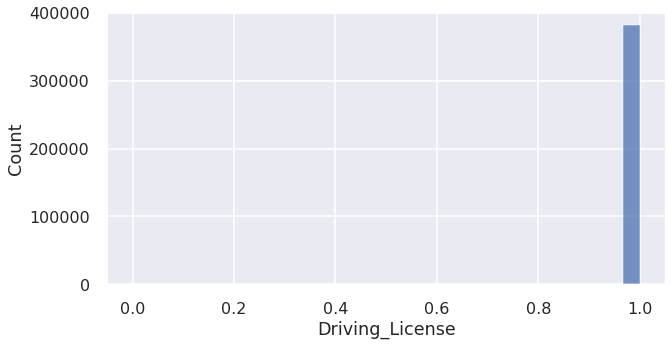

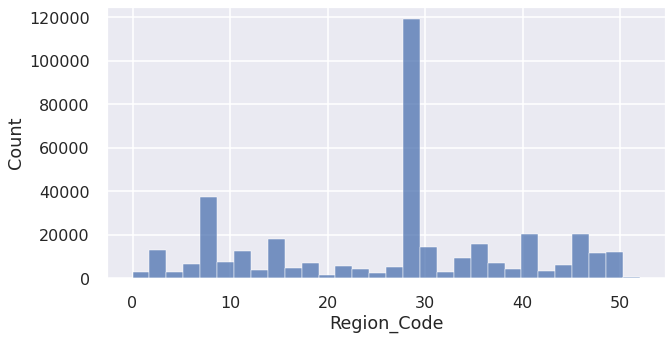

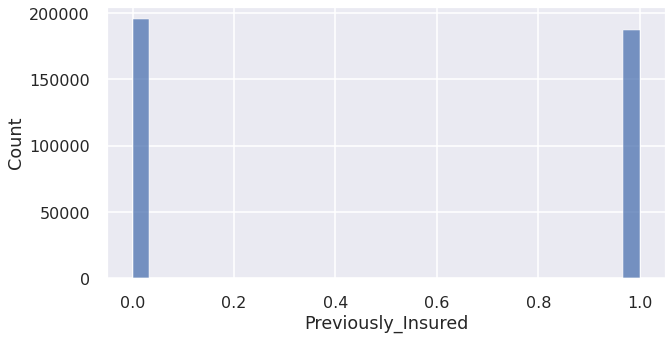

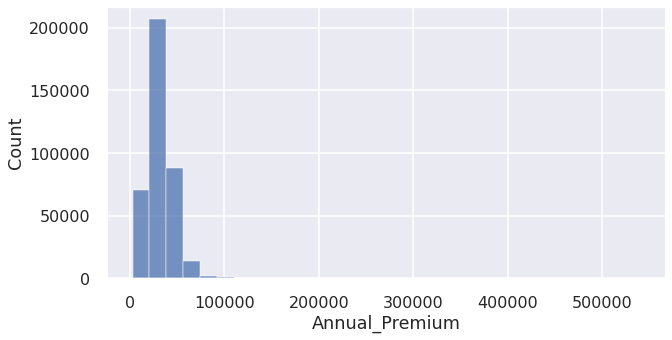

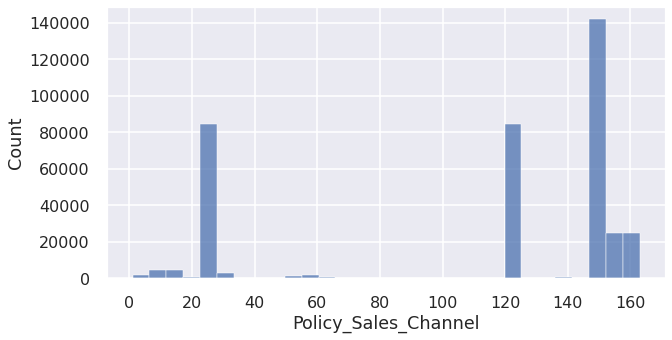

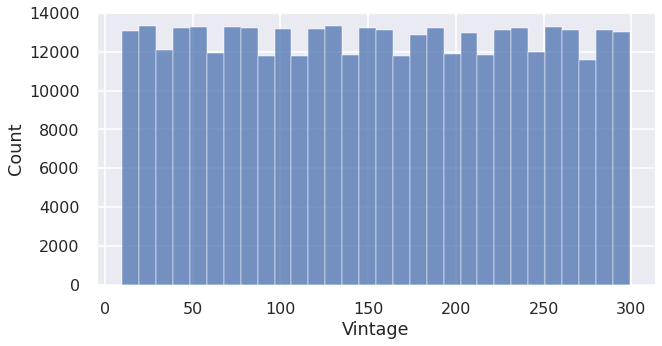

In [386]:
for col in numerical_columns:
        plt.subplots(figsize=(10,5))
        sns.histplot(data[col], label='train', bins=30)

### Age

In [363]:
data.Age.value_counts()

24    26197
23    24424
25    21056
22    20844
21    15770
      ...  
81       52
82       32
83       24
84       14
85       10
Name: Age, Length: 66, dtype: int64

The vast majority of ages are between 20 and 50, I opt to create bins here to reduce the number of potential ages.

In [364]:
data[data['Age']<30]['Age'].count()/len(data)

0.4079402544523935

In [365]:
data['Age'][data.Age.between(30,50)].count()/len(data)

0.3714261789749682

In [366]:
data['Age'][data['Age']>50].count()/len(data)

0.22063356657263825

### Driving license

In [367]:
data.Driving_License.value_counts()

1    381431
0       723
Name: Driving_License, dtype: int64

In [368]:
data.Driving_License.value_counts(normalize=True)

1   0.998
0   0.002
Name: Driving_License, dtype: float64

There are only 0,002 % of drivers who do not have driving license. People without a drivers license would not be interested in vehicle insurance, for that reason we can drop this column.

### Region code

In [369]:
data.Region_Code.value_counts().head()

28.000    107199
8.000      33941
46.000     20203
41.000     19090
15.000     13071
Name: Region_Code, dtype: int64

In [370]:
data.Region_Code.value_counts(normalize=True).head()

28.000   0.281
8.000    0.089
46.000   0.053
41.000   0.050
15.000   0.034
Name: Region_Code, dtype: float64

We can see that the majority of region codes is number 28 which is approx 28% of all codes and number 8 which is approx 9%. We can consider making 3 region classes - '28', '8' and 'other'. To make it possible I will change type of this feature to string and then use one hot encoding on it.

### Annual premium

In [371]:
data.Annual_Premium.value_counts()

2630.000     62876
69856.000      133
38452.000       47
45179.000       45
36086.000       40
             ...  
59458.000        1
55907.000        1
59514.000        1
21088.000        1
54157.000        1
Name: Annual_Premium, Length: 48993, dtype: int64

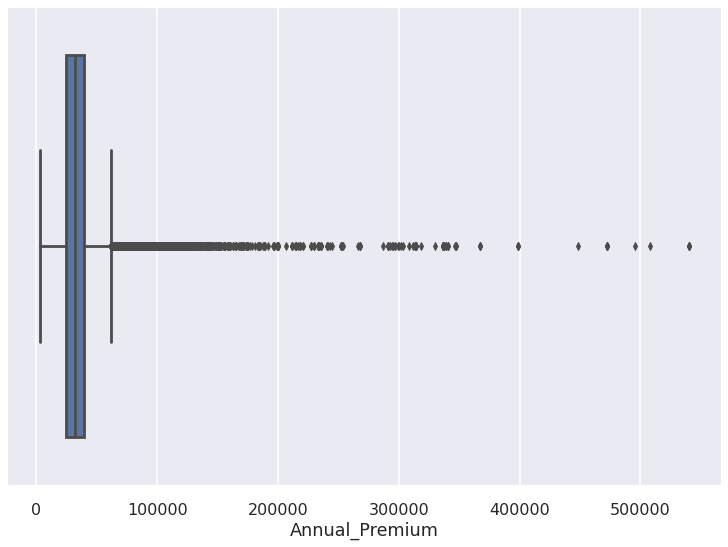

In [372]:
sns.boxplot(data.Annual_Premium)

We can see that there are a lot of outliers in annual premium values, therefore I wont remove them, because they can be helpful indicators for our model. I will handle it by creating bins for value ranges.

In [373]:
data[data['Annual_Premium']<30000]['Annual_Premium'].count()/len(data)

0.43467031615526724

In [374]:
data[data.Annual_Premium.between(30000,50000)]['Annual_Premium'].count()/len(data)

0.48050524134249545

In [375]:
data[data['Annual_Premium']>50000]['Annual_Premium'].count()/len(data)

0.08482444250223732

### Policy sales channel

In [376]:
data.Policy_Sales_Channel.value_counts()

152.000    137422
26.000      81566
124.000     73315
160.000     21045
156.000     10106
            ...  
143.000         1
144.000         1
84.000          1
141.000         1
41.000          1
Name: Policy_Sales_Channel, Length: 156, dtype: int64

We can see 5 main policy sales channel which are '152', '26', '124', '160', '156'. For the rest of channels we can make group 'other' and put them into it. For that reason I will change it to the string type and then make one hot encoding. 

# Numerical conclusion.

* id - drop
* Driving_License - drop
* Vintage - drop
* Age - bins(<30, 30-50, >50)
* Region_code - (28, 8, other)
* Policy_Sales_Channel - ('152', '26', '124', '160', '156',  'other')
* Annual_Premium - bins(<30000, 30000-50000, >50000)

# Categorial columns.

Same as in prevoius step but for categorial columns. Instead of plotting hists I am plotting bars which counts observations in each categorical.

In [377]:
for col in categorial_columns:
    print(f'{col}')
    print(f'unique values number: {data[col].nunique()}')
    print(f'{data[col].unique()}')
    print()

Gender
unique values number: 2
['Male' 'Female']

Vehicle_Age
unique values number: 3
['< 1 Year' '1-2 Year' '> 2 Years']

Vehicle_Damage
unique values number: 2
['No' 'Yes']



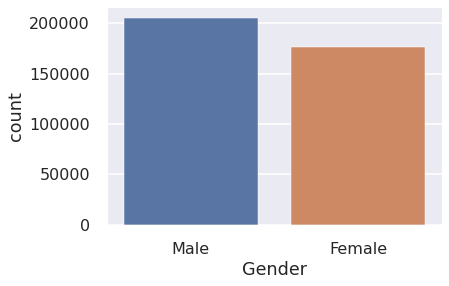

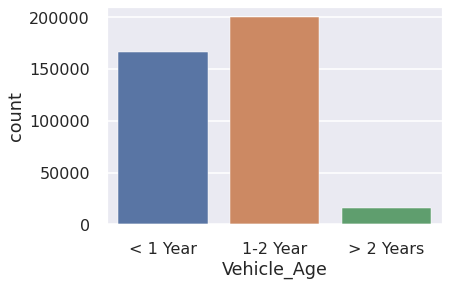

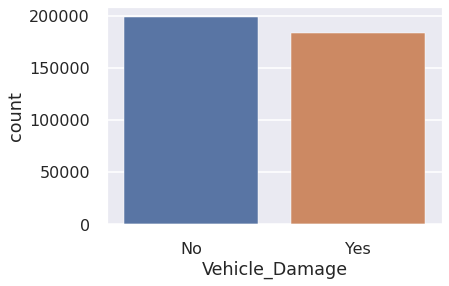

In [382]:
for col in categorial_columns:
        plt.subplots(figsize=(6,4))
        sns.countplot(data[col], label='train')

### Gender

In [77]:
data.Gender.value_counts()

Male      205603
Female    176551
Name: Gender, dtype: int64

### Vehicle age

In [78]:
data.Vehicle_Age.value_counts()

1-2 Year     200176
< 1 Year     166353
> 2 Years     15625
Name: Vehicle_Age, dtype: int64

### Vehicle damage

In [79]:
data.Vehicle_Damage.value_counts()

No     198501
Yes    183653
Name: Vehicle_Damage, dtype: int64

#  Categorical conclusion.

* Gender - binary 
* Vehicle_Age - one hot encoding
* Vehicle_Damage - binary 

# Correlation matrix analysis.

There I want to create the correlation matrix to show which variable is having a high or low correlation in respect to another variable. First I am creating loop to encode categorial features using LabelEncoder and then I am plotting it using heatmap and concatenate function.

In [387]:
data_heat = data.drop('id', axis=1)

for c in categorial_columns:
    le = LabelEncoder()
    le.fit(list(data_heat[c]))
    data_heat[c] = le.transform(list(data_heat[c])) 
data_heat.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,22,1,7.000,1,1,0,2630.000,152.000,16,0
1,1,42,1,28.000,0,0,1,43327.000,26.000,135,0
2,0,66,1,33.000,0,0,1,35841.000,124.000,253,0
3,0,22,1,33.000,0,1,0,27645.000,152.000,69,0
4,1,28,1,46.000,1,1,0,29023.000,152.000,211,0


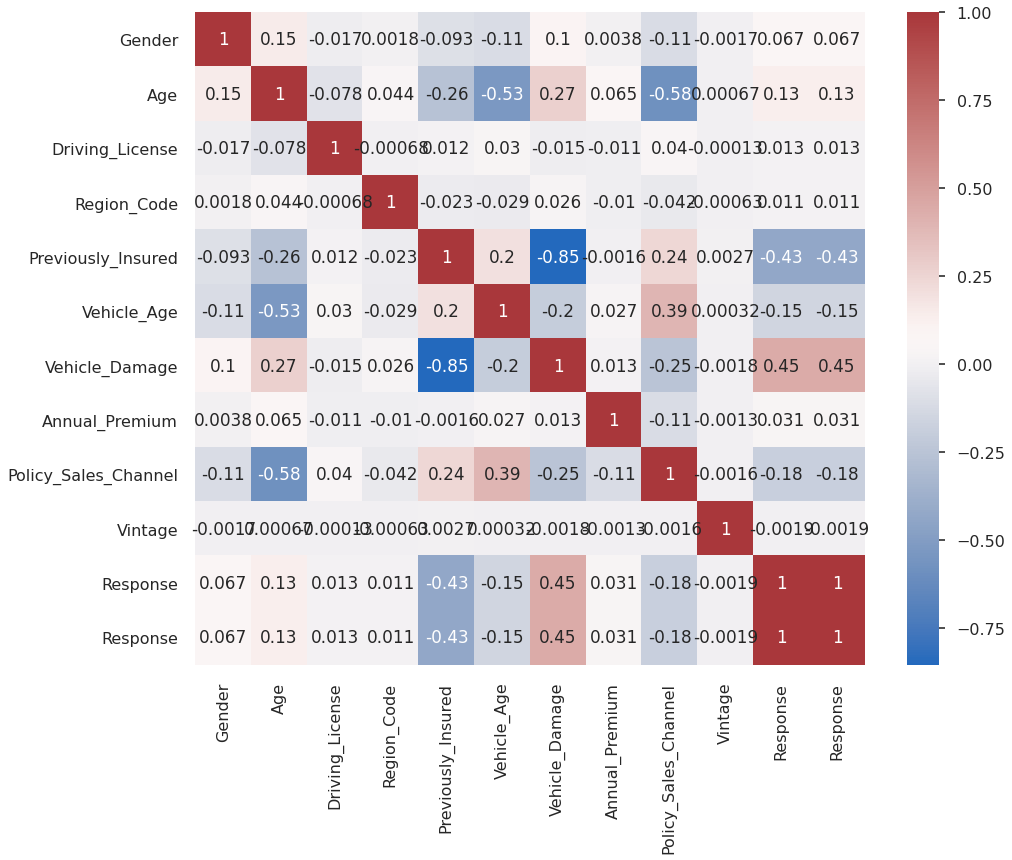

In [390]:
plt.figure(figsize=(15, 12))
sns.heatmap(pd.concat([data_heat, target], axis=1).corr(),annot=True, cmap="vlag") 

We can see that the strongest negative correlation occur between Vehicle Damage and Previously Insured. It can results from the fact that people who had their vehicle damaged once decidet to bought insurance. From the heatmap we can also read a moderate negative correlation between Policy Sales Channel and Age and between Age and Vehicle Age.

# Data preparation.

In this step I will create a function to prepare dataset for modeling. Function contains 4 sections. Firstly it drops features which we rejected in data analysis, secondly it changes feature type from numeric to string to enable encoding, thirdly it makes transformations on numerical columns in our case its binning. The last step transforming categorial columns - it makes mapping and binary encoding. Function returns prepared data with use of dummies encoding.

In [17]:
# mapping function for region code
def map_Region_Code(x):
    if x not in ['28', '8']:
        return 'Other'
    else:
        return x

In [18]:
# mapping function for policy sales channel
def map_Policy_Sales_Channel(x):
    if x not in ['152', '26', '124', '160', '156']:
        return 'Other'
    else:
        return x

In [19]:
def prepare_dataset(df):
    
    # columns to drop
    df.pop('id')
    df.pop('Vintage')
    df.pop('Driving_License')
    
    # numerical to string
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype(int).astype('str')
    df['Region_Code'] = df['Region_Code'].astype(int).astype('str')

    
    # numerical columns
    df['Age'] = pd.cut(x=df['Age'], bins=[0,30,50,100], right=False, labels=['1','2','3'])
    df['Annual_Premium'] = pd.cut(x=df['Annual_Premium'], bins=[0,30000,50000,600000], right=False, labels=['1','2','3'])
    
    # categorial columns
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].apply(lambda x: map_Policy_Sales_Channel(x))
    df['Region_Code'] = df['Region_Code'].apply(lambda x: map_Region_Code(x))
    df['Gender'] = df['Gender'].apply(lambda x: 1 if x=='Male' else 0) 
    df['Vehicle_Damage'] = df['Vehicle_Damage'].apply(lambda x: 1 if x=='No' else 0)
    df['Vehicle_Age'].replace({'1-2 Year' : '1',
                                '< 1 Year' : '0',
                                '> 2 Years' : '2'}, inplace=True)
    return pd.get_dummies(df, drop_first=True)
    

In [20]:
processed_data = prepare_dataset(data)
processed_data.head()

,Gender,Previously_Insured,Vehicle_Damage,Response,Age_2,Age_3,Region_Code_8,Region_Code_Other,Vehicle_Age_1,Vehicle_Age_2,Annual_Premium_2,Annual_Premium_3,Policy_Sales_Channel_152,Policy_Sales_Channel_156,Policy_Sales_Channel_160,Policy_Sales_Channel_26,Policy_Sales_Channel_Other
0,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0
2,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0
4,1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0


# Modeling.

Now i am splitting processed dataset into X - features and y - target. To split data into train/test I will use StratifiedKFold function. I chose this one because it will enable me to make cross-validation od data as well.

In [128]:
X = processed_data.drop('Response',axis=1)
y = processed_data.Response

In [129]:
# defining folds parameters
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

poniewaz problem niezbalansowany to rezugnujemy z metryki accuracy


### Choosing metrics to measure model performance

To measure model performance I've choosen two metrics roc_auc and f1_score. Roc_auc will show how good at ranking predictions my model is and f1_score will show weighted average of the precision and recall. In this case I will try to maximize f1_score, becasue dataset is imbalanced and I care more about the positive class.

### Defining baseline models

I am defining models without parameters which will be baseline for future modeling.

In [130]:
models = [LogisticRegression(),
          DecisionTreeClassifier(),
          RandomForestClassifier(),
          XGBClassifier()]

names = ['LR', 'DT', 'RF', 'XGB']

### Defining models with params

Here I am defining tuned models with parameters on which we will try to get best prediction scores.

In [131]:
models_param = [LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=300),
                DecisionTreeClassifier(max_depth=5, criterion='gini', max_features=0.8, min_samples_split=5),
                RandomForestClassifier(criterion='entropy', max_depth=30, random_state=42),
                XGBClassifier(max_depth=6, learning_rate=0.1, min_child_weight=5, reg_lambda=2, max_leaves=12)]

names = ['LR', 'DT', 'RF', 'XGB']

### Defining metric function for baseline models

I am creating function which will print baseline models chosen metrics (auc and f1 score).The function cross-validate models and then append metric scores to its variables. As the output we get mean metrics scores form each baseline cross-validated model.

In [146]:
def get_models_metrics(models, names, X, y):  

    
    for model, name in zip(models, names):
        
        score_auc = []
        score_f1 = []
        probas_model = np.zeros(len(X))
        
        for train_index, test_index in folds.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
            model.fit(X_train, y_train)
            probas_model[test_index] = model.predict_proba(X_test)[:, 1]
        
            score_auc.append(roc_auc_score(y_test, probas_model[test_index]))
            score_f1.append(f1_score(y_test, np.where(probas_model[test_index] > 0.5, 1, 0)))
        print(f'{name}: AUC = %.5f, F1-score = %.5f' % (np.mean(score_auc), np.mean(score_f1) ))

### Checking baseline models scores

In [147]:
get_models_metrics(models, names, X, y)

LR: AUC = 0.87350, F1-score = 0.21874
DT: AUC = 0.88142, F1-score = 0.29864
RF: AUC = 0.88174, F1-score = 0.29816
XGB: AUC = 0.88204, F1-score = 0.30305


### Defining function with tuned models and their metrics

This function works almost the same as get_models_metrics function. The only change is that I am operating on tuned models and I am choosing model to evaluate by passing its name to the function. It also contains the new parameter thres which allows me to calibrate threshold.

In [162]:
def tuned_models_metrics(name, X, y, thres=0.5):
    
    if name == 'lr':
        model = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=300)

    elif name == 'dt':
        model = DecisionTreeClassifier(max_depth=5, criterion='gini', max_features=0.8, min_samples_split=5)
        
    elif name == 'rf':
        model = RandomForestClassifier(criterion='entropy', max_depth=30, random_state=42)
        
    elif name == 'xgb':
        model = XGBClassifier(max_depth=6, learning_rate=0.1, min_child_weight=5, reg_lambda=2, max_leaves=12)
        
    else:
        print('Error, invalid model')
        

    
    score_auc = []
    probas_model = np.zeros(len(X))
    score_f1 = []
    
    for train_index, test_index in folds.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)                 
        probas_model[test_index] = model.predict_proba(X_test)[:, 1]
        
        score_auc.append(roc_auc_score(y_test, probas_model[test_index]))
        score_f1.append(f1_score(y_test, np.where(probas_model[test_index] > thres, 1, 0)))
    
    print(f'{name}: AUC = %.5f, F1-score = %.5f' % (np.mean(score_auc), np.mean(score_f1) ))

### Checking tuned models scores

In [163]:
tuned_models_metrics('lr', X, y)

lr: AUC = 0.87319, F1-score = 0.54549


In [164]:
tuned_models_metrics('dt', X, y)

dt: AUC = 0.87380, F1-score = 0.20814


In [165]:
tuned_models_metrics('rf', X, y)

rf: AUC = 0.88180, F1-score = 0.29811


In [166]:
tuned_models_metrics('xgb', X, y)

xgb: AUC = 0.88356, F1-score = 0.29426


We can see that AUC scores for baseline models and tuned models are quite high, but F1-scores are very bad.

### greed for xgb

In [23]:
xgb = XGBClassifier(**cv.best_params_)

params = {"max_depth": [3,4,5],
         "min_child_weight": [3, 5, 7, 10 ,15]}
cv2 = GridSearchCV(param_grid=params, estimator=xgb,cv=4)
cv2.fit(X_train,y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(learning_rate=0.10957265958868737,
                                     max_depth=5, min_child_weight=15,
                                     n_estimators=200,
                                     reg_lambda=1.3403244203429763),
             param_grid={'max_depth': [3, 4, 5],
                         'min_child_weight': [3, 5, 7, 10, 15]})

In [24]:
cv2.best_score_, cv2.best_params_

(0.8413302260384619, {'max_depth': 5, 'min_child_weight': 10})

# Threshold callibration

For those classification problems that have a severe class imbalance, the default threshold can result in poor performance. As such, a simple and straightforward approach to improving the performance of a classifier that predicts probabilities on an imbalanced classification problem is to tune the threshold used to map probabilities to class labels.

source: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

This function hepls with finding approximately the best threshold for my tunned models.

In [169]:
def threshold_calibration(models, names, X, y):
    threshold_list = {}
    thresholds = []
    fscore = []
    ix = []
    folds1 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    for model, name in zip(models, names):
        for train_index, test_index in folds1.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
            model.fit(X_train, y_train)

            threshold_list[name] = model.predict_proba(X_test)[:, 1]
            precision, recall, thresholds = precision_recall_curve(y_test, threshold_list[name])
            fscore = (2 * precision * recall) / (precision+ recall)
            ix = np.nanargmax(fscore)
            print(name)
            print('Best Threshold=%.2f, F-measure=%.5f' % (thresholds[ix], fscore[ix]))
  

# Resampling dataset

Resampling is a method that consists of drawing repeated samples from the original data samples. 

In [171]:
# imports for resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

### Undersampling

Undersampling involves randomly selecting examples from the majority class and deleting them from the training dataset. In the random under-sampling, the majority class instances are discarded at random until a more balanced distribution is reached.

source: https://betterprogramming.pub/resampling-imbalanced-data-and-applying-ml-techniques-91ebce40ff4d

In [176]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

In [177]:
X_res.shape, y_res.shape

((125202, 12), (125202,))

In [178]:
y_res.sum()/len(y_res)

0.5

We can se that now we have equal number of examples in target.

In [179]:
get_models_metrics(models, names, X_res, y_res)

LR: AUC = 0.87176, F1-score = 0.84166
DT: AUC = 0.87852, F1-score = 0.84310
RF: AUC = 0.87958, F1-score = 0.84334
XGB: AUC = 0.88073, F1-score = 0.84538


In [180]:
tuned_models_metrics('lr', X_res, y_res)

lr: AUC = 0.87176, F1-score = 0.84166


In [181]:
tuned_models_metrics('dt', X_res, y_res)

dt: AUC = 0.87373, F1-score = 0.84153


In [182]:
tuned_models_metrics('rf', X_res, y_res)

rf: AUC = 0.87963, F1-score = 0.84326


In [183]:
tuned_models_metrics('xgb', X_res, y_res)

xgb: AUC = 0.88208, F1-score = 0.84512


In [184]:
threshold_calibration(models_param, names, X_res, y_res)

LR
Best Threshold=0.45, F-measure=0.84315
LR
Best Threshold=0.44, F-measure=0.84339
LR
Best Threshold=0.45, F-measure=0.84318
DT
Best Threshold=0.52, F-measure=0.84250
DT
Best Threshold=0.54, F-measure=0.84297
DT
Best Threshold=0.45, F-measure=0.84411
RF
Best Threshold=0.39, F-measure=0.84552
RF
Best Threshold=0.42, F-measure=0.84592
RF
Best Threshold=0.36, F-measure=0.84515
XGB
Best Threshold=0.41, F-measure=0.84661
XGB
Best Threshold=0.42, F-measure=0.84663
XGB
Best Threshold=0.44, F-measure=0.84650


In [185]:
tuned_models_metrics('xgb', X_res, y_res, thres=0.42)

xgb: AUC = 0.88208, F1-score = 0.84642


We can se that undersampling hepled a lot for our models. The best score we got is for tunned XGBoost with threshold = 0.42

Now lets try undersampling one more time but with making minority class 2 time smaller than majority.

In [188]:
rus = RandomUnderSampler(sampling_strategy=0.5) 
X_res, y_res = rus.fit_resample(X, y)

In [189]:
X_res.shape, y_res.shape

((187803, 12), (187803,))

In [191]:
y_res.sum()/len(y_res)

0.3333333333333333

In [192]:
get_models_metrics(models, names, X_res, y_res)

LR: AUC = 0.87313, F1-score = 0.73246
DT: AUC = 0.88091, F1-score = 0.73570
RF: AUC = 0.88137, F1-score = 0.73622
XGB: AUC = 0.88176, F1-score = 0.73446


We can see that we got worse scores on with this minority class.

### Tomek Links

In [240]:
%%time
from imblearn.under_sampling import TomekLinks
tl = TomekLinks(sampling_strategy='auto', n_jobs=-1)
X_res, y_res = tl.fit_resample(X, y)

CPU times: user 18min 52s, sys: 690 ms, total: 18min 53s
Wall time: 6min 47s


In [241]:
X.shape, X_res.shape

((382154, 12), (382154, 12))

We can see that Tomek Links didnt remove any observation from our dataset. I think it can be the result of that algorithm didnt find any pairs of very close instances, but of opposite classes, therefore it coulndt remove instances of the majority class. Tomek Links is inefficient algorithm for our dataset.

### Oversampling

Oversampling involves randomly duplicating examples from the minority class and adding them to the training dataset.

In [204]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_res, y_res = ros.fit_resample(X, y)

In [205]:
X_res.shape, X.shape

((639106, 12), (382154, 12))

In [206]:
y_res.sum()/len(y_res)

0.5

In [207]:
get_models_metrics(models, names, X_res, y_res)

LR: AUC = 0.87310, F1-score = 0.84216
DT: AUC = 0.88376, F1-score = 0.84558
RF: AUC = 0.88381, F1-score = 0.84564
XGB: AUC = 0.88227, F1-score = 0.84556


In [208]:
tuned_models_metrics('lr', X_res, y_res)

lr: AUC = 0.87310, F1-score = 0.84216


In [209]:
tuned_models_metrics('dt', X_res, y_res)

dt: AUC = 0.87317, F1-score = 0.84295


In [210]:
tuned_models_metrics('rf', X_res, y_res)

rf: AUC = 0.88381, F1-score = 0.84556


In [211]:
tuned_models_metrics('xgb', X_res, y_res)

xgb: AUC = 0.88381, F1-score = 0.84578


In [212]:
threshold_calibration(models_param, names, X_res, y_res)

LR
Best Threshold=0.45, F-measure=0.84300
LR
Best Threshold=0.44, F-measure=0.84473
LR
Best Threshold=0.45, F-measure=0.84405
DT
Best Threshold=0.41, F-measure=0.84301
DT
Best Threshold=0.52, F-measure=0.84371
DT
Best Threshold=0.52, F-measure=0.84340
RF
Best Threshold=0.41, F-measure=0.84658
RF
Best Threshold=0.44, F-measure=0.84819
RF
Best Threshold=0.43, F-measure=0.84750
XGB
Best Threshold=0.44, F-measure=0.84658
XGB
Best Threshold=0.43, F-measure=0.84797
XGB
Best Threshold=0.42, F-measure=0.84747


In [214]:
tuned_models_metrics('xgb', X_res, y_res, thres=0.43)

xgb: AUC = 0.88381, F1-score = 0.84714


We can see that with the use of oversampling we got slightly better scores than using undersampling. It is probably the reason of adding some extra samples from which model could better learn. The best score we got again on tunned XGBoost with threshold = 0.43.

### SMOTE

In [218]:
smote = SMOTE(sampling_strategy='auto')
X_res, y_res = smote.fit_resample(X, y)

In [219]:
X_res.shape, X.shape

((639106, 12), (382154, 12))

In [220]:
y_res.sum()/len(y_res)

0.5

In [221]:
get_models_metrics(models, names, X_res, y_res)

LR: AUC = 0.87366, F1-score = 0.84307
DT: AUC = 0.88443, F1-score = 0.84659
RF: AUC = 0.88450, F1-score = 0.84659
XGB: AUC = 0.88279, F1-score = 0.84653


In [222]:
tuned_models_metrics('lr', X_res, y_res)

lr: AUC = 0.87366, F1-score = 0.84307


In [223]:
tuned_models_metrics('dt', X_res, y_res)

dt: AUC = 0.87656, F1-score = 0.84242


In [224]:
tuned_models_metrics('rf', X_res, y_res)

rf: AUC = 0.88451, F1-score = 0.84669


In [225]:
tuned_models_metrics('xgb', X_res, y_res)

xgb: AUC = 0.88458, F1-score = 0.84714


In [226]:
threshold_calibration(models_param, names, X_res, y_res)

LR
Best Threshold=0.45, F-measure=0.84386
LR
Best Threshold=0.45, F-measure=0.84508
LR
Best Threshold=0.46, F-measure=0.84514
DT
Best Threshold=0.52, F-measure=0.84298
DT
Best Threshold=0.51, F-measure=0.84473
DT
Best Threshold=0.52, F-measure=0.84472
RF
Best Threshold=0.42, F-measure=0.84787
RF
Best Threshold=0.37, F-measure=0.84875
RF
Best Threshold=0.39, F-measure=0.84908
XGB
Best Threshold=0.43, F-measure=0.84774
XGB
Best Threshold=0.42, F-measure=0.84858
XGB
Best Threshold=0.43, F-measure=0.84894


In [227]:
tuned_models_metrics('xgb', X_res, y_res, thres=0.43)

xgb: AUC = 0.88458, F1-score = 0.84832


For SMOTE resampling the scores of our models improved a little. We can try to use smote with different sampling strategy and check how it will affect the scoring.

In [237]:
smote = SMOTE(sampling_strategy=0.5)
X_res, y_res = smote.fit_resample(X, y)

In [238]:
y_res.sum()/len(y_res)

0.33333263791675444

In [239]:
get_models_metrics(models, names, X_res, y_res)

LR: AUC = 0.87330, F1-score = 0.73235
DT: AUC = 0.88353, F1-score = 0.73822
RF: AUC = 0.88362, F1-score = 0.73842
XGB: AUC = 0.88239, F1-score = 0.73483


We can see that when we reduce minority class size, scores of models also decrease.

### ADASYN

In [280]:
%%time
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(sampling_strategy='auto', n_jobs=-1)
X_res, y_res = adasyn.fit_resample(X, y)

CPU times: user 7min 46s, sys: 1.84 s, total: 7min 47s
Wall time: 4min 49s


In [249]:
X_res.shape, X.shape

((635007, 12), (382154, 12))

In [254]:
y_res.sum()/len(y_res)

0.49677247652388085

In [257]:
get_models_metrics(models, names, X_res, y_res)

LR: AUC = 0.85597, F1-score = 0.83530
DT: AUC = 0.87886, F1-score = 0.83701
RF: AUC = 0.87891, F1-score = 0.83704
XGB: AUC = 0.86768, F1-score = 0.83734


In [244]:
tuned_models_metrics('lr', X_res, y_res)

lr: AUC = 0.85597, F1-score = 0.83609


In [245]:
tuned_models_metrics('dt', X_res, y_res)

dt: AUC = 0.85692, F1-score = 0.83558


In [262]:
tuned_models_metrics('rf', X_res, y_res)

rf: AUC = 0.87891, F1-score = 0.83700


In [247]:
tuned_models_metrics('xgb', X_res, y_res)

xgb: AUC = 0.87610, F1-score = 0.83715


In [281]:
threshold_calibration(models_param, names, X_res, y_res)

LR
Best Threshold=0.40, F-measure=0.83731
LR
Best Threshold=0.43, F-measure=0.83844
LR
Best Threshold=0.44, F-measure=0.83817
DT
Best Threshold=0.44, F-measure=0.83779
DT
Best Threshold=0.45, F-measure=0.83841
DT
Best Threshold=0.48, F-measure=0.83852
RF
Best Threshold=0.39, F-measure=0.83932
RF
Best Threshold=0.41, F-measure=0.84067
RF
Best Threshold=0.40, F-measure=0.83998
XGB
Best Threshold=0.43, F-measure=0.83911
XGB
Best Threshold=0.42, F-measure=0.84036
XGB
Best Threshold=0.41, F-measure=0.83983


In [282]:
tuned_models_metrics('rf', X_res, y_res, thres=0.41)

rf: AUC = 0.87890, F1-score = 0.83989


We can see that ADASYN also improved metrics of our models but were less effective than SMOTE.

## Oversampling and Underampling

In [283]:
%%time
from imblearn.combine import SMOTETomek

smt = SMOTETomek(n_jobs=-1)

X_res, y_res = smt.fit_resample(X, y)

CPU times: user 59min 48s, sys: 5.55 s, total: 59min 53s
Wall time: 26min 49s


In [269]:
X_res.shape, X.shape

((639106, 12), (382154, 12))

In [270]:
y_res.sum()/len(y_res)

0.5

In [271]:
get_models_metrics(models, names, X_res, y_res)

LR: AUC = 0.87378, F1-score = 0.84340
DT: AUC = 0.88440, F1-score = 0.84682
RF: AUC = 0.88442, F1-score = 0.84696
XGB: AUC = 0.88269, F1-score = 0.84672


In [272]:
tuned_models_metrics('lr', X_res, y_res)

lr: AUC = 0.87380, F1-score = 0.84339


In [273]:
tuned_models_metrics('dt', X_res, y_res)

dt: AUC = 0.87245, F1-score = 0.84001


In [274]:
tuned_models_metrics('rf', X_res, y_res)

rf: AUC = 0.88444, F1-score = 0.84696


In [275]:
tuned_models_metrics('xgb', X_res, y_res)

xgb: AUC = 0.88442, F1-score = 0.84719


In [284]:
threshold_calibration(models_param, names, X_res, y_res)

LR
Best Threshold=0.45, F-measure=0.84394
LR
Best Threshold=0.45, F-measure=0.84487
LR
Best Threshold=0.46, F-measure=0.84514
DT
Best Threshold=0.41, F-measure=0.84362
DT
Best Threshold=0.54, F-measure=0.84409
DT
Best Threshold=0.52, F-measure=0.84435
RF
Best Threshold=0.41, F-measure=0.84753
RF
Best Threshold=0.41, F-measure=0.84867
RF
Best Threshold=0.43, F-measure=0.84874
XGB
Best Threshold=0.44, F-measure=0.84736
XGB
Best Threshold=0.43, F-measure=0.84853
XGB
Best Threshold=0.42, F-measure=0.84871


In [286]:
tuned_models_metrics('rf', X_res, y_res, thres=0.41)

rf: AUC = 0.88413, F1-score = 0.84825


In [292]:
tuned_models_metrics('xgb', X_res, y_res, thres=0.44)

xgb: AUC = 0.88423, F1-score = 0.84792


For SMOTETomek our baseline models have better scores than with usng SMOTE alone. When I tunned xgb with threshold = 0.44 I got the best score from all of the tests. For that reason I consider SMOTETomek as a best resampling method for our dataset.

# GreedSearchCV for XGBoost.

In this step I will try try to get better score for XGBoost algorithm by using GreedSearcgCV.

In [298]:
xgb = XGBClassifier()
params = {"n_estimators":[10,100,200],
         "learning_rate":ss.uniform(0.01,0.3),
          "max_depth": ss.randint(5,30),
         "min_child_weight":ss.randint(5,50),
         "reg_lambda":ss.uniform(0.1,3),
         "max_leaves":[10,12,20]}

cvgs = RandomizedSearchCV(cv=3, 
                        estimator=xgb,
                        param_distributions=params,
                        n_iter=20,
                        verbose=100,
                        scoring='f1',
                        n_jobs=-1)
cvgs.fit(X_res,y_res)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  8.

RandomizedSearchCV(cv=3, estimator=XGBClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f60fdb43100>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f60fb099430>,
                                        'max_leaves': [10, 12, 20],
                                        'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f60fb082bb0>,
                                        'n_estimators': [10, 100, 200],
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f60fdb43640>},
                   scoring='f1', verbose=100)

In [299]:
cvgs.best_score_, cvgs.best_params_

(0.8466492464109039,
 {'learning_rate': 0.23530105903146123,
  'max_depth': 9,
  'max_leaves': 10,
  'min_child_weight': 13,
  'n_estimators': 100,
  'reg_lambda': 1.5489323990151924})

In [340]:
best_model = [XGBClassifier(learning_rate=0.23530105903146123,
                            max_depth=9,
                            max_leaves=10,
                            min_child_weight=13,
                            n_estimators=100,
                            reg_lambda=1.5489323990151924)]
best_name = ['xgb']

In [341]:
# in this loop i want to extract from xgboost model probabilities for the target, and then in teh next step
# print a confusion matrix
    for model, name in zip(best_model, best_name):
        
        probas_model = np.zeros(len(X_res))
        
        for train_index, test_index in folds.split(X_res, y_res):
            X_train, X_test = X_res.iloc[train_index], X_res.iloc[test_index]
            y_train, y_test = y_res.iloc[train_index], y_res.iloc[test_index]
        
            model.fit(X_train, y_train)
            probas_model[test_index] = model.predict_proba(X_test)[:, 1]

In [306]:
from sklearn.metrics import confusion_matrix

# Confusion matrix.

For the last step in my anasysis I am creating confusion matrix for xgb to evaluate the accuracy of a classification.

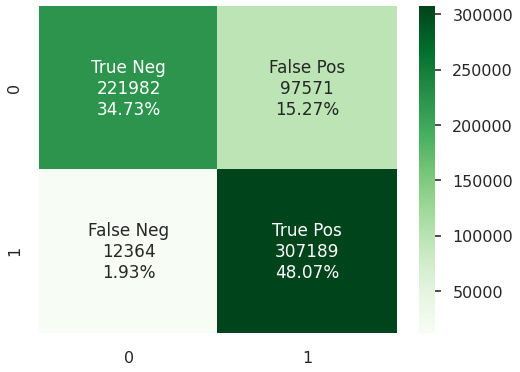

In [344]:
probas_model = np.where(probas_model > 0.5, 1, 0)
cf_matrix = confusion_matrix(y_res, probas_model) 
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)
plt.style.use('seaborn-poster')
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greens')

We can see that our model predicts TP very good but also has a small problem with prediction TN correct.

# Conclusions

* The bussines problem was to find the segment of clients which will be the most willing to get car insurance,
* The problem was imbalanced, therefore I had to prepare the dataset and then use different resampling methods to improve algorithms get better performance,
* For this bussines problem I've choosen F1-score to test and evaluate models becasue this metric works very good on imbalanced data and we were more focused on predicting possitive class,
* SMOTE and SMOTETomek were two resampling methods which were the most appropriate for our dataset,
* XGBoost algorithm had the best results, after tunning it had approximately AUC: 0,88 and F1-score: 0,85.